In [9]:
# Importing necessary libraries
import matplotlib.pyplot as plt  # For plotting graphs
import networkx as nx  # For handling graph structures
import numpy as np  # For numerical operations
from heapq import heappush, heappop
from itertools import count
from networkx.algorithms.community.centrality import girvan_newman
import time

def edge_betweenness_centrality(G, normalized=True):
    """
    Calculates the edge-betweenness-centrality score for each edge in graph G.
    """
    # Initialize betweenness centrality dictionary for all nodes and edges with zero
    betweenness = dict.fromkeys(G, 0.0)  
    betweenness.update(dict.fromkeys(G.edges(), 0.0))

    # Iterate over all nodes to calculate betweenness centrality
    for node in G.nodes():
        # Perform Dijkstra's algorithm to find shortest paths from the node
        S, parent, sigma = single_source_dijkstra(G, node)
        # Aggregate betweenness centrality from these paths
        betweenness = get_betweenness(betweenness, S, parent, sigma, node)
    # Remove node keys from the dictionary, keeping only edges
    for n in G.nodes():
        del betweenness[n]
    # Normalize or rescale betweenness centrality values if needed
    betweenness = rescale_edges(betweenness, len(G), normalized=normalized, directed=G.is_directed())
    return betweenness

def single_source_dijkstra(G, node):
    """
    Implements Dijkstra's algorithm to find the shortest paths from a single source node to all other nodes in the graph.
    """
    # Initialize structures for storing shortest paths, parents, and path counts
    S = []  # Stack to store nodes in the order they are processed
    parent = {v: [] for v in G}  # Dictionary to store parent nodes in paths
    sigma = dict.fromkeys(G, 0.0)  # Dictionary to store the number of shortest paths
    distance = {}  # Dictionary to store distances from source
    sigma[node] = 1.0  # Start with the source node
    seen = {node: 0}  # Seen nodes
    Q = []  # Priority queue for managing frontier
    heappush(Q, (0, next(count()), node, node))  # Push the source node into the queue

    # Process the queue
    while Q:
        (dist, _, pred, u) = heappop(Q)
        if u in distance:
            continue
        sigma[u] += sigma[pred]  # Update path count
        S.append(u)  # Add to stack
        distance[u] = dist  # Set distance
        for v, edgedata in G[u].items():
            uv_dist = dist + edgedata.get(None, 1)  # Calculate distance to neighbor
            if v not in distance and (v not in seen or uv_dist < seen[v]):
                seen[v] = uv_dist
                heappush(Q, (uv_dist, next(count()), u, v))
                sigma[v] = 0.0
                parent[v] = [u]
            elif uv_dist == seen[v]:  # Another shortest path found
                sigma[v] += sigma[u]
                parent[v].append(u)
    return S, parent, sigma

def get_betweenness(betweenness, S, parent, sigma, s):
    """
    Helper function to update betweenness centrality values based on the shortest path information.
    """
    delta = dict.fromkeys(S, 0)  # Delta values for accumulation
    # Process nodes in reverse order
    while S:
        v = S.pop()
        coeff = (1 + delta[v]) / sigma[v]
        for u in parent[v]:
            c = sigma[u] * coeff
            if (u, v) not in betweenness:
                betweenness[(v, u)] += c
            else:
                betweenness[(u, v)] += c
            delta[u] += c
        if v != s:
            betweenness[v] += delta[v]
    return betweenness

def rescale_edges(betweenness, n, normalized, directed=False, k=None):
    """
    Rescales betweenness centrality values based on graph properties and desired normalization.
    """
    scale = None
    if normalized:
        if n <= 1:
            scale = None
        else:
            scale = 1 / (n * (n - 1))  # Normalization factor for directed/undirected graphs
    else:
        if not directed:
            scale = 0.5  # Adjust for undirected graphs
        else:
            scale = None
    if scale is not None:
        if k is not None:
            scale *= n / k  # Adjust scale if considering a subset of nodes
        for u in betweenness:
            betweenness[u] *= scale
    return betweenness

def edge_to_remove(graph):
    """
    Identifies the edge with the highest betweenness centrality to remove during each iteration of the Girvan-Newman algorithm.
    """
    ebc_per_edge = edge_betweenness_centrality(graph)
    # Find the edge with the highest betweenness centrality value
    edge = max(ebc_per_edge.items(), key=lambda item: item[1])[0]
    return edge

def girvan_newman(graph, num_communities):
    """
    Implements the Girvan-Newman algorithm to detect a specified number of communities by iteratively removing edges.
    """
    # Initialize connected components and count them
    cc_node_set = list(nx.connected_components(graph))
    cc_count = len(cc_node_set)
    removed_edges = []

    # Iteratively remove edges until the desired number of communities is achieved
    while cc_count < num_communities:
        edge = edge_to_remove(graph)
        removed_edges.append(edge)
        graph.remove_edge(*edge)
        cc_node_set = list(nx.connected_components(graph))
        cc_count = len(cc_node_set)
    return cc_node_set, removed_edges

def get_remaining_edges(graph, removed_edges):
    """
    Removes any remaining edges from the list of previously removed edges, ensuring the graph reflects the latest community structure.
    """
    for edge in removed_edges:
        if edge in graph.edges:
            graph.remove_edge(*edge)
    return graph

### Zachary's Karate Club

import matplotlib.pyplot as plt
import networkx as nx


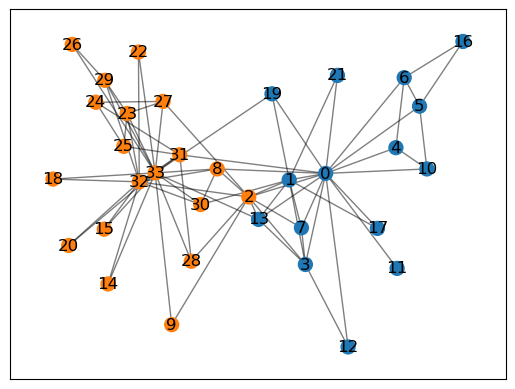

Execution time: 0.2128 seconds


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import time
from networkx.algorithms.community import girvan_newman

def apply_girvan_newman(G):
    """Apply Girvan-Newman algorithm to split the graph into exactly two communities."""
    comp = girvan_newman(G)
    # Get the top level communities (first split into two groups)
    limited = tuple(sorted(c) for c in next(comp))
    return limited

def visualize_graph(G, communities):
    """Visualizes the graph with nodes colored by their community membership."""
    pos = nx.spring_layout(G)
    # Assign colors for the two communities
    color_map = []
    for node in G:
        if node in communities[0]:
            color_map.append('tab:blue')
        else:
            color_map.append('tab:orange')
    
    nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=100)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos)
    plt.show()

def main():
    start_time = time.perf_counter()
    G = nx.karate_club_graph()  # Load Zachary's Karate Club graph
    communities = apply_girvan_newman(G)  # Apply Girvan-Newman algorithm
    visualize_graph(G, communities)  # Visualize the graph
    end_time = time.perf_counter()
    print(f"Execution time: {end_time - start_time:.4f} seconds")

if __name__ == "__main__":
    main()
